# Analyze network consequences of protein abundance changes - PCMT1
Currently set up for a single model
## Setup
### Import packages

In [10]:
import io
import re
import shutil
import tempfile
import warnings
import zipfile
from operator import attrgetter
from pathlib import Path
from warnings import warn

import gurobipy as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sympy
from cobra.core import get_solution
from cobra.flux_analysis import find_blocked_reactions
from cobra.flux_analysis.variability import flux_variability_analysis
from cobra.manipulation import remove_genes
from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    get_dirpath,
    handle_msg,
    read_cobra_model,
    show_versions,
    write_cobra_model,
)
from rbc_gem_utils.analysis.overlay import (
    DEFAULT_PREFIX_SUFFIX_VALUES,
    DEFAULT_PROTEOME_COMPARTMENT,
    ComplexDilution,
    ProteinDilution,
    add_relaxation_budget,
    load_overlay_model,
    update_slack_value,
)
from rbc_gem_utils.util import AVOGADRO_NUMBER, DEFAULT_DRY_MASS_PER_CELL

gp.setParam("OutputFlag", 0)
gp.setParam("LogToConsole", 0)

# Show versions of notebook
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.3

Dependency Information
----------------------
beautifulsoup4                       4.13.4
bio                                   1.8.0
cobra                                0.29.1
depinfo                               2.2.0
gurobipy                             12.0.3
matplotlib                           3.10.3
matplotlib-venn                       1.1.2
memote                               0.17.0
networkx                                3.5
notebook                              7.4.4
openpyxl                              3.1.5
pandas                                2.3.1
pre-commit                            4.2.0
rbc-gem-utils[database,network,vis] missing
requests                             2.32.4
scikit-learn                          1.7.0
scipy                                1.16.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip          25.1
setuptools 78.1.1
wheel      0.45

### Define configuration
#### COBRA Configuration

In [11]:
COBRA_CONFIGURATION.solver = "gurobi"
# Set bound defaults much larger to prevent model loading issues due to protein constraint bounds
COBRA_CONFIGURATION.bounds = (-1e8, 1e8)
COBRA_CONFIGURATION

Attribute,Description,Value
solver,Mathematical optimization solver,gurobi
tolerance,"General solver tolerance (feasibility, integrality, etc.)",1e-07
lower_bound,Default reaction lower bound,-100000000.0
upper_bound,Default reaction upper bound,100000000.0
processes,Number of parallel processes,127
cache_directory,Path for the model cache,C:\Users\P7875\AppData\Local\opencobra\cobrapy\Cache
max_cache_size,Maximum cache size in bytes,104857600
cache_expiration,Model cache expiration time in seconds (if any),None


### Define organism, model, and dataset

In [12]:
organism = "Human"
model_id = "RBC_GEM"
dataset_name = "DeepRed"

### Set computation options

In [13]:
protein_of_interest = "PCMT1"
reaction_of_interest = "PROTISODMT_L"

ftype = "xml"  # In our experience, SBML/XML loads faster, but will take up to 4x more space uncompressed as compared to JSON
run_computations = True  # Keep off to use previously computed results
overwrite = True  # Whether to allow overwriting of previous simulation results
verbose = True

# Objective reactions
objective_reactions = ["NaKt"]
# Reactions that must have the capability to carry flux, sort for consistency
required_flux_reactions = []  # Add reactions to this list
required_flux_reactions = sorted(set(objective_reactions + required_flux_reactions))

min_relax_budget_for_objectives = True
# Remove blocked reactions before pcFVA simulation.
# For large models and/or multiple runs at different optimums, will speed up computation and potentially improve results.
remove_blocked_reactions = True
# Relaxation reactions that should be restricted to inactive
protein_relaxations_to_restrict = ["G6PD"]
# Protein constraints that need lower bounds relaxed to prevent increase of
# associated subunits in direct conflict with physiologically known.
# Setting the lower bound prevents from being required.
protein_constraints_lb_to_relax = []

zip_kwargs = dict(compression=zipfile.ZIP_DEFLATED, compresslevel=None)

#### Set prefixes/suffixes to expect

In [14]:
protein_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.dilution"]
protein_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.metabolite"]
relaxation_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["proteins"]["prefix.relaxation"]
enzyme_met_suffix_total = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["suffix.total"]
enzyme_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.dilution"]
enzyme_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["enzymes"]["prefix.metabolite"]
budget_rxn_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.dilution"]
budget_met_prefix = DEFAULT_PREFIX_SUFFIX_VALUES["budgets"]["prefix.metabolite"]
comp_suffix = f"_{DEFAULT_PROTEOME_COMPARTMENT}"

### Set figure options

In [15]:
save_figures = True
transparent = False
imagetype = "svg"

### Set paths

In [16]:
# Set paths
processed_data_dirpath = get_dirpath(use_temp="processed") / organism / dataset_name
# Set paths
overlay_dirpath = get_dirpath("analysis") / "OVERLAY" / organism
model_dirpath = overlay_dirpath / model_id
results_dirpath = (
    get_dirpath(use_temp="processed") / model_id / "OVERLAY" / organism / dataset_name
)
fitting_dirpath = results_dirpath / "fitting"
sample_pcmodels_dirpath = results_dirpath / "pcmodels"
abundance_change_results_path = results_dirpath / "abundance_changes"

# Ensure directories exist
abundance_change_results_path.mkdir(exist_ok=True, parents=True)

## Load RBC-GEM model

In [17]:
model = read_cobra_model(filename=model_dirpath / f"{model_id}.xml")

ftype = "xml"
with zipfile.ZipFile(f"{sample_pcmodels_dirpath}.zip", "r") as zfile:
    with zfile.open(f"{model_id}_PC_{dataset_name}.{ftype}", "r") as model_file:
        pcmodel = load_overlay_model(
            filename=io.StringIO(model_file.read().decode("utf-8")), filetype=ftype
        )
pcmodel

Name,RBC_GEM_PC_DeepRed
Memory address,25014fbec10
Number of metabolites,7785
Number of reactions,15624
Number of genes,723
Number of groups,68
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space, protein compartment"


### Set protein of interest

In [18]:
protein_gene = pcmodel.genes.get_by_id(protein_of_interest)
protein_met = pcmodel.metabolites.get_by_id(
    f"{protein_met_prefix}{protein_of_interest}{comp_suffix}"
)
protein_rxn = pcmodel.reactions.get_by_id(f"{protein_rxn_prefix}{protein_met.id}")

# Store IDs for later use
protein_mid = protein_met.id
protein_rid = protein_rxn.id
protein_relax_id = f"{relaxation_rxn_prefix}{protein_mid}"

biochemical_reactions = []
for reaction in sorted(protein_gene.reactions, key=attrgetter("id")):
    if reaction in model.reactions:
        print(model.reactions.get_by_id(reaction.id))
        biochemical_reactions += [reaction.id]
required_flux_reactions = list(
    set(required_flux_reactions).union(biochemical_reactions)
)
protein_gene

PROTDMT_D: amet__L_c + protres_asp__D_c --> ahcys__L_c + protres_aspmeo__D_c
PROTISODMT_L: amet__L_c + protres_isoasp__L_c --> ahcys__L_c + protres_isoaspmeo__L_c


Gene identifier,PCMT1
Name,PIMT
Memory address,0x25088a8f310
Functional,True
In 13 reaction(s),"ENZFM_enzyme_PROTDMT_D_fwd_cplx_MONOMER_PCMT1_pc, ENZFM_enzyme_PROTISODMT_L_fwd_cplx_MONOMER_PCMT1_pc, ENZDL_enzyme_PROTISODMT_L_fwd_pc, PROTISODMT_L, ENZDL_enzyme_PROTDMT_D_rev_pc,..."


### Get original values from model

In [19]:
budget_met_relaxation = pcmodel.metabolites.get_by_id(f"{budget_met_prefix}relaxation")
budget_rxn_relaxation = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}relaxation"
)

orig_relax_budget = budget_rxn_relaxation.bounds
orig_protein_bounds = protein_rxn.bounds

### Define helper functions

In [20]:
def find_and_remove_blocked_reactions(
    pcmodel, relaxation_rxns_required=None, prevent_removal=None, verbose=False
):
    pcmodel = pcmodel.copy()
    n_reactions_original = len(pcmodel.reactions)
    n_genes_original = len(pcmodel.genes)
    pcmodel.objective = sum(
        [
            r.flux_expression
            for r in pcmodel.reactions.get_by_any(required_flux_reactions)
        ]
    )
    if prevent_removal is None:
        prevent_removal = []
    for relax_rxn in pcmodel.reactions.query(
        lambda x: x.id.startswith(relaxation_rxn_prefix)
    ):
        if relax_rxn.id in relaxation_rxns_required:
            continue
        else:
            relax_rxn.bounds = (0, 0)
    reactions_to_remove = find_blocked_reactions(
        model=pcmodel,
        reaction_list=None,
        zero_cutoff=COBRA_CONFIGURATION.tolerance,
        open_exchanges=True,
        processes=min(60, COBRA_CONFIGURATION.processes),
    )
    reactions_to_remove = sorted(
        set(reactions_to_remove).difference(
            [
                rxn
                for prot in prevent_removal
                for rxn in [
                    f"{protein_rxn_prefix}{protein_met_prefix}{prot}{comp_suffix}",
                    f"{relaxation_rxn_prefix}{protein_met_prefix}{prot}{comp_suffix}",
                ]
            ]
        )
    )
    pcmodel.remove_reactions(reactions_to_remove, remove_orphans=True)
    genes_to_remove = [
        gene.id
        for gene in pcmodel.genes
        if not pcmodel.reactions.has_id(
            f"{protein_rxn_prefix}{protein_met_prefix}{gene.id}{comp_suffix}"
        )
        and not pcmodel.reactions.has_id(
            f"{relaxation_rxn_prefix}{protein_met_prefix}{gene.id}{comp_suffix}"
        )
    ]
    genes_to_remove = sorted(set(genes_to_remove).difference(prevent_removal))
    remove_genes(pcmodel, gene_list=genes_to_remove, remove_reactions=True)
    handle_msg(
        f"Number of blocked reactions removed: {n_reactions_original - len(pcmodel.reactions)}",
        print_msg=verbose,
    )
    handle_msg(
        f"Number of associated genes removed: {n_genes_original - len(pcmodel.genes)}",
        print_msg=verbose,
    )
    return pcmodel

### Ensure model can optimize all reactions catalyzed by protein of interest

In [21]:
print("Old relaxation bounds: ({:.6f}, {:.6f})".format(*orig_relax_budget))

# Restrict relaxation reactions for specific proteins
for protein in protein_relaxations_to_restrict:
    protein_met = pcmodel.metabolites.get_by_id(
        f"{protein_met_prefix}{protein}{comp_suffix}"
    )
    relax_prot_rxn = pcmodel.reactions.get_by_id(
        f"{relaxation_rxn_prefix}{protein_met.id}"
    )
    relax_prot_rxn.bounds = (0, 0)
# Relax lower bound constraint for specific proteins
for protein in protein_constraints_lb_to_relax:
    protein_met = pcmodel.metabolites.get_by_id(
        f"{protein_met_prefix}{protein}{comp_suffix}"
    )
    protein_rxn = pcmodel.reactions.get_by_id(f"{protein_rxn_prefix}{protein_met.id}")
    protein_rxn.lower_bound = 0

budget_rxn_relaxation = pcmodel.reactions.get_by_id(
    f"{budget_rxn_prefix}{budget_met_prefix}relaxation"
)
# Determine smallest allowable relxation budget that allows flux through objectives and set as upper bound
with pcmodel:
    pcmodel.objective = (
        sum(
            [
                r.flux_expression
                for r in pcmodel.reactions.get_by_any(required_flux_reactions)
            ]
        )
        - budget_rxn_relaxation.flux_expression
    )
    pcmodel.objective_direction = "max"
    # Fail loudly, should not occur unless a restricted relaxation proteins are absolutely necessary
    pcmodel.slim_optimize(error_value=None)
    relaxation_rxns_required = get_solution(
        pcmodel,
        reactions=pcmodel.reactions.query(
            lambda x: x.id.startswith(relaxation_rxn_prefix)
        ),
    )
    relaxation_rxns_required = set(
        relaxation_rxns_required.fluxes[
            relaxation_rxns_required.fluxes != 0
        ].index.to_list()
    )
    budget_min = budget_rxn_relaxation.flux
if min_relax_budget_for_objectives:
    budget_rxn_relaxation.upper_bound = budget_min
print("New relaxation bounds: ({:.6f}, {:.6f})".format(*budget_rxn_relaxation.bounds))
with warnings.catch_warnings(action="ignore"):
    pcmodel = find_and_remove_blocked_reactions(
        pcmodel,
        relaxation_rxns_required=relaxation_rxns_required,
        prevent_removal=list(
            set(protein_relaxations_to_restrict)
            .union(protein_constraints_lb_to_relax)
            .union([protein_of_interest])
        ),
        verbose=verbose,
    )

pcmodel.objective = sum(
    [r.flux_expression for r in pcmodel.reactions.get_by_any(required_flux_reactions)]
)

sol = pcmodel.optimize(raise_error=True)

# Display solution for required flux capable reactions
objective_sol = sol.fluxes.loc[required_flux_reactions]
print(f"Optimization objective: {sol.objective_value:.6f}\n{objective_sol}")
# Protein utilized
protein_sol = sol.fluxes.loc[[protein_rid, protein_relax_id]]
print(f"\nProtein utilized: {protein_sol.sum():.6f}\n{protein_sol}")
# Required relaxation budget
relax_sol = sol.fluxes.loc[
    pcmodel.reactions.query(
        lambda x: x.id.startswith(relaxation_rxn_prefix)
        or x.id.endswith(budget_met_relaxation.id)
    ).list_attr("id")
]
relax_sol = relax_sol[relax_sol != 0]
relax_budget_used = relax_sol.loc[budget_rxn_relaxation.id]
print(
    f"\nTotal relaxation budget utilized: {relax_budget_used:.6f} ({relax_budget_used / budget_rxn_relaxation.upper_bound:.4%})\n{relax_sol}"
)
pcmodel

Old relaxation bounds: (0.002343, 9.685002)
New relaxation bounds: (0.002343, 0.363709)
Number of blocked reactions removed: 2003
Number of associated genes removed: 82
Optimization objective: 0.583282
NaKt            0.164874
PROTDMT_D       0.000000
PROTISODMT_L    0.418408
Name: fluxes, dtype: float64

Protein utilized: 3.698659
PROTDL_protein_PCMT1_pc    3.698659
RELAX_protein_PCMT1_pc     0.000000
Name: fluxes, dtype: float64

Total relaxation budget utilized: 0.363709 (100.0000%)
BDL_budget_relaxation        0.363709
RELAX_protein_ADH5_pc        2.438016
RELAX_protein_ATP1A3_pc      0.706301
RELAX_protein_ATP1B3_pc      0.706301
RELAX_protein_ATP6V0B_pc     0.013810
RELAX_protein_ATP6V0E1_pc    0.013810
RELAX_protein_ESD_pc         0.844322
RELAX_protein_MPI_pc         0.172778
RELAX_protein_RPE_pc         0.159618
RELAX_protein_SLC16A9_pc     1.041456
RELAX_protein_SLC7A1_pc      0.984968
RELAX_protein_SLC7A6_pc      0.012175
RELAX_protein_TSPO2_pc       0.065261
Name: fluxes, d

Name,RBC_GEM_PC_DeepRed
Memory address,250138fe550
Number of metabolites,7249
Number of reactions,13621
Number of genes,641
Number of groups,68
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e + 1.0*PROTDMT_D - 1.0*PROTDMT_D_reverse_31221 +...
Compartments,"cytosol, extracellular space, protein compartment"


## Optimal fluxes as a function of reduction in protein abundance

In [22]:
percent_interval = (0, -100)
proteome_rxns_of_interest = [
    protein_rid,
    protein_relax_id,
]
biochemical_rxns_of_interest = [
    "PROTISODMT_L",
]

solutions = []
with pcmodel:
    protein_reaction = pcmodel.reactions.get_by_id(protein_rid)
    pcmodel.objective = sum(
        [
            rxn.flux_expression
            for rxn in pcmodel.reactions.get_by_any(required_flux_reactions)
        ]
    )

    for percent in np.linspace(
        *percent_interval, 1 + (percent_interval[0] - percent_interval[1])
    ):
        protein_reaction.bounds = (
            orig_protein_bounds[0] * (1 + percent / 100),
            orig_protein_bounds[1] * (1 + percent / 100),
        )
        sol = pcmodel.optimize()
        sols_of_interest = sol.fluxes.loc[
            biochemical_rxns_of_interest
            + [
                x
                for x in required_flux_reactions
                if x not in biochemical_rxns_of_interest
            ]
            + [x for x in proteome_rxns_of_interest if x not in required_flux_reactions]
        ]
        sols_of_interest.name = percent
        solutions.append(sols_of_interest)

df_solutions = pd.concat(solutions, axis=1)
df_solutions

,0.0,-1.0,-2.0,-3.0,-4.0,-5.0,-6.0,-7.0,-8.0,-9.0,...,-91.0,-92.0,-93.0,-94.0,-95.0,-96.0,-97.0,-98.0,-99.0,-100.0
PROTISODMT_L,0.418408,0.418408,0.418408,0.418408,0.418408,0.418408,0.418408,0.418408,0.418408,0.418408,...,0.249347,0.221641,0.193936,0.166231,0.138526,0.110821,0.083116,0.055410,0.027705,0.000000
NaKt,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,...,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874,0.164874
PROTDMT_D,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PROTDL_protein_PCMT1_pc,3.698659,3.661673,3.624686,3.587699,3.550713,3.513726,3.476740,3.439753,3.402766,3.365780,...,0.336242,0.298882,0.261521,0.224161,0.186801,0.149441,0.112081,0.074720,0.037360,0.000000
RELAX_protein_PCMT1_pc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Plot results for flux as a function of protein abundance

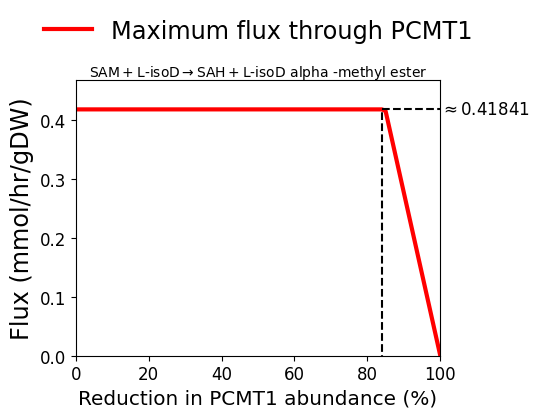

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.5))
# sns.despine(fig)
approx_label_fmt = "$\\approx{:.5f}$"
xmin, xmax = tuple([-1 * x for x in percent_interval])
# Plot G6PDH2
PROTISODMT_L_flux = df_solutions.loc[["PROTISODMT_L"]].sum(axis=0)
# For reduction only, switch percentage sign for downward slope
PROTISODMT_L_flux.index *= -1
PROTISODMT_L_flux.plot(
    ax=ax,
    color="red",
    linewidth=3,
    label=f"Maximum flux through {protein_of_interest}",
)
ax.annotate(
    "$\\text{SAM} + \\text{L-isoD} \\rightarrow \\text{SAH} + \\text{L-isoD}\ \\text{\\alpha -methyl ester}$\n",
    xy=(0.5, 1.00),
    ha="center",
    va="center",
    xycoords="axes fraction",
    fontsize="medium",
)


xpad = 0
ypad = 0.05
ax.set_xlim(xmin - xpad, xmax)
ax.set_ylim(0, PROTISODMT_L_flux.max() + ypad)
ax.xaxis.set_tick_params(labelsize="large")
ax.yaxis.set_tick_params(labelsize="large")
ax.set_xlabel(f"Reduction in {protein_of_interest} abundance (%)", fontsize="x-large")
ax.set_ylabel("Flux (mmol/hr/gDW)", fontsize="xx-large")
ax.legend(
    bbox_to_anchor=(0.5, 1.3), loc="upper center", frameon=False, fontsize="xx-large"
)


ymax = PROTISODMT_L_flux.max()
ax.annotate(
    approx_label_fmt.format(ymax),
    xy=(100, ymax * 0.98),
    xycoords="data",
    fontsize="large",
)

pct = 84
ls = "--"
color = "black"
ax.vlines(
    x=pct,
    ymin=PROTISODMT_L_flux.min() - ypad,
    ymax=ymax,
    linestyle=ls,
    color=color,
    linewidth=1.5,
)
ax.hlines(y=ymax, xmin=pct, xmax=100, linestyle=ls, color=color, linewidth=1.5)

fig.tight_layout()
if save_figures:
    ftypes = ["png", "svg"]
    for ftype in ftypes:
        fig.savefig(
            abundance_change_results_path
            / f"Reduction_{protein_of_interest}_PanelA.{ftype}",
            transparent=transparent,
            format=ftype,
        )